# Кредитный скоринг

Предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Цель: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Задачи:
- провести чистку данных;
- сделать разведку признаков;
- визуализировать данные;
- обучить модель;
- оценить значимость признаков для модели;
- получить значение ROC AUC;
- применить регуляризацию.

## Import

In [1]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
import os
import datetime as dt
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn
import matplotlib.ticker as ticker

plt.style.use('seaborn-deep')
sns.set_style("whitegrid")
sns.axes_style("whitegrid")

warnings.filterwarnings('ignore')


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


%matplotlib inline

# Setting the conditions for experiments.
random_seed = 42
pd.set_option('display.max_columns', None)
data_directory = '/kaggle/input/sf-dst-scoring/'
!pip freeze > requirements.txt

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


## Functions

In [2]:
# Вынесем все функции в начало

def outliers_detection(col):
    Q1, Q3 = np.percentile(col, [25, 75])
    IQR = Q3 - Q1
    lower_border = Q1 - (IQR * 1.5)
    upper_border = Q3 + (IQR * 1.5)
    # возращаем значения и индексы за пределами нижней и верхней границ
    return col[((col > upper_border) | (col < lower_border))]

def drop_outliers(data, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    data = data.loc[col.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)]

    
def get_boxplot(column):

    # plot boxplots for numerical features

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x='default',
                y=column,
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column, fontsize=16, pad=20)
    plt.rcParams.update({'font.size': 14})
    plt.show()

In [3]:
def confusion_matrix_plot(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cf_matrix = np.array([[tp, fp], [fn, tn]])
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure()
    color_text = plt.get_cmap('PuBuGn')(0.95)
    sns.heatmap(cf_matrix,
                annot=labels,
                annot_kws={"size": 20},
                fmt='',
                cmap='PuBuGn',
                cbar=False,
                xticklabels=['Дефолт', 'Не дефолт'],
                yticklabels=['Дефолт', 'Не дефолт'])
    plt.ylabel('Предсказанные значения', fontsize=15, color=color_text)
    plt.xlabel('Реальные значения', fontsize=15, color=color_text)
    plt.title('Матрица ошибок', fontsize=16, pad=20)
    plt.rcParams['figure.figsize'] = (6, 6)
    plt.show()

    
def all_metrics(y_test, y_pred, y_pred_prob):
    result = pd.Series({
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_pred_prob)
    })
    return result

## Data

In [4]:
# Загрузим данные
data_directory = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(data_directory+'train.csv')
df_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

## EDA

In [5]:
# Посмотрим на три случайные записи
df.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
31484,1399,05JAN2014,UGR,F,23,N,N,5,0,-0.895746,0,50,2,3,20000,1,3,N,1.0,1
57832,6409,13JAN2014,UGR,F,31,N,N,0,0,-1.190518,3,80,2,3,50000,1,4,Y,0.0,1
53705,49593,26FEB2014,SCH,F,49,N,N,1,1,-1.449623,5,80,2,3,40000,1,3,N,1.0,1


In [6]:
# посмотрим на типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

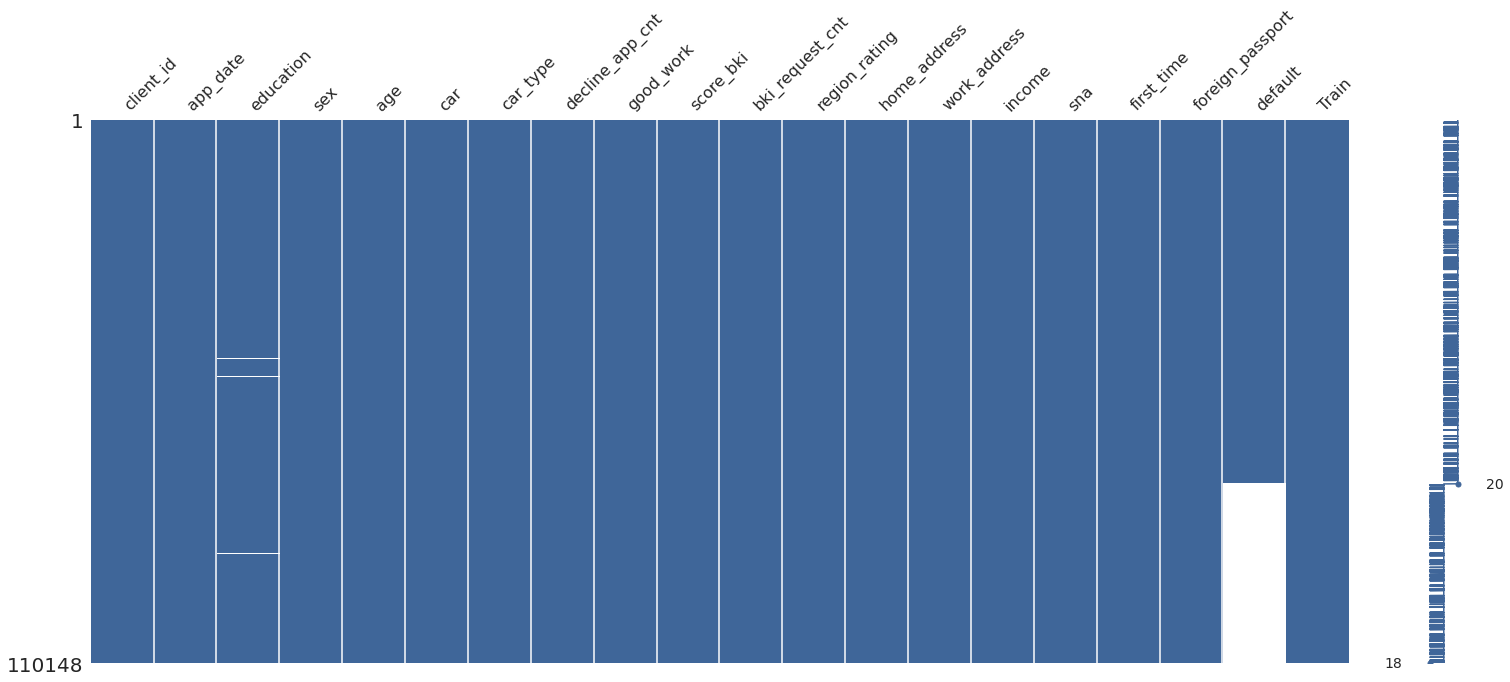

In [7]:
# Отобразим имеющиеся пропуски
msgn.matrix(df, color=(0.25, 0.4, 0.6))
plt.show()

In [8]:
# Получим процентный список пропущенных значений
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))
    
# Подсчет значений для категориальных столбцов (просмотр уникальных значений)
for col in df.columns:
    print('\nColumn Name:', col,)
    print(df[col].value_counts().sort_index())

print('Размерность тренировочного датасета: ', df_train.shape, '\n')
print('Размерность тестовго датасета: ', df_test.shape)

for i in df.columns:
    print(df[i].unique())

client_id - 0.0%
app_date - 0.0%
education - 0.0%
sex - 0.0%
age - 0.0%
car - 0.0%
car_type - 0.0%
decline_app_cnt - 0.0%
good_work - 0.0%
score_bki - 0.0%
bki_request_cnt - 0.0%
region_rating - 0.0%
home_address - 0.0%
work_address - 0.0%
income - 0.0%
sna - 0.0%
first_time - 0.0%
foreign_passport - 0.0%
default - 33.0%
Train - 0.0%

Column Name: client_id
1         1
2         1
3         1
4         1
5         1
         ..
110144    1
110145    1
110146    1
110147    1
110148    1
Name: client_id, Length: 110148, dtype: int64

Column Name: app_date
01APR2014    1239
01FEB2014     794
01JAN2014      56
01MAR2014     848
02APR2014    1291
             ... 
30APR2014     865
30JAN2014    1187
30MAR2014     722
31JAN2014    1216
31MAR2014    1317
Name: app_date, Length: 120, dtype: int64

Column Name: education
ACD      291
GRD    34768
PGR     1865
SCH    57998
UGR    14748
Name: education, dtype: int64

Column Name: sex
F    61836
M    48312
Name: sex, dtype: int64

Column Name: ag

# Описание

Мы имеем 73799 записей в тренировочных данных и 36349 - в тестовых.  
Всего 18 нецелевых признаков: 
- client_id - идентификатор клиента  
- education - уровень образования  
- sex - пол заемщика  
- age - возраст заемщика  
- car - флаг наличия автомобиля  
- car_type - флаг автомобиля иномарки  
- decline_app_cnt - количество отказанных прошлых заявок  
- good_work - флаг наличия “хорошей” работы  
- bki_request_cnt - количество запросов в БКИ  
- home_address - категоризатор домашнего адреса  
- work_address - категоризатор рабочего адреса  
- income - доход заемщика  
- foreign_passport - наличие загранпаспорта  
- sna - связь заемщика с клиентами банка  
- first_time - давность наличия информации о заемщике  
- score_bki - скоринговый балл по данным из БКИ  
- region_rating - рейтинг региона  
- app_date - дата подачи заявки  

Целевой признак «default» - флаг дефолта по кредиту, имеется только для тренировочных данных и в них не имеет пропусков.

Пропуски имеются только у признака «education» - %.

### Бинарные переменные:
- sex ('M', 'F')
- car ('Y', 'N')
- car_type ('Y', 'N')
- foreign_passport ('N', 'Y')
- good_work

### Категориальные переменные:
- education ('SCH', 'GRD', 'UGR', 'PGR', 'ACD')
- work_address
- home_address
- sna
- first_time
- region_rating
- app_date (содержит в себе дату обращения, все записи за 2014 год с января по апрель)

### Числовые переменные:
- age
- decline_app_cnt
- income
- bki_request_cnt
- score_bki

In [9]:
# Creating a new feature.
df['education_nan'] = pd.isna(df['education']).astype('uint8')

In [10]:
# заменим пропуски
df.education = df.education.fillna(df.education.describe()['top'])

In [11]:
# Посмотрим на признак client_id
df.client_id.astype('object').describe(include = 'object')

count     110148
unique    110148
top       110148
freq           1
Name: client_id, dtype: int64

Признак «client_id» - уникальный идентификатор клиента, не повторяется. Смысловой нагрузки не несет, его можно не использовать.

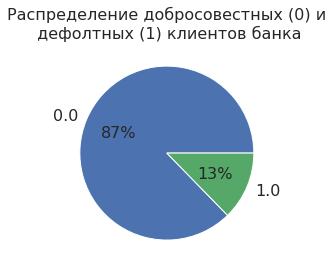

In [12]:
# Посмотрим на соотношение добросовестных и дефолтных клиентов банка
df['default'].value_counts().plot(kind='pie',
                                        autopct='%1.0f%%',
                                        fontsize=16)

plt.title('''Распределение добросовестных (0) и
 дефолтных (1) клиентов банка''',
          fontsize=16)
plt.ylabel(None)
plt.show()
plt.rcParams["figure.figsize"] = [10, 8]

Из графика следует, что классы несбалансированы - дефолтов меньше, чем возвращенных кредитов.

Визуализируем распределения параметров, чтобы понять, имеют ли дефолтные кредиты отличающееся распределение.

In [13]:
# Выделим признаки по типу
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna',
            'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

In [14]:
# Для бинарных признаков используем LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,education_nan
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,0
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,0
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,0
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,0


In [15]:
# преобразуем признак «образование» в числовой признак 
edu = {
    'SCH': 1,
    'GRD': 2,
    'UGR': 3,
    'PGR': 4,
    'ACD': 5
}

df['education'] = df['education'].replace(to_replace=edu)

Обработаем признак «app_date»

In [16]:
# преобразуем «app_date» в формат даты
df['app_date'] = pd.to_datetime(df.app_date, format='%d%b%Y')
df['app_date'].sample(3)

76145   2014-01-24
4234    2014-01-07
69626   2014-01-17
Name: app_date, dtype: datetime64[ns]

In [17]:
date_min = min(df['app_date'])
print('Самая ранняя дата:', date_min)
date_max = max(df['app_date'])
print('Самая поздняя дата:', date_max)

Самая ранняя дата: 2014-01-01 00:00:00
Самая поздняя дата: 2014-04-30 00:00:00


Видим, что в наборе данные с января по апрель 2014 года.

In [18]:
# Создадим новый признак - количество дней от 1 января
df['date_timedelta'] = (df['app_date'] - date_min).dt.days.astype('int')

# Добавим его к количественным признакам
num_cols.append('date_timedelta')

Text(0.5, 1.0, 'Распределение заявок по дням от начала года')

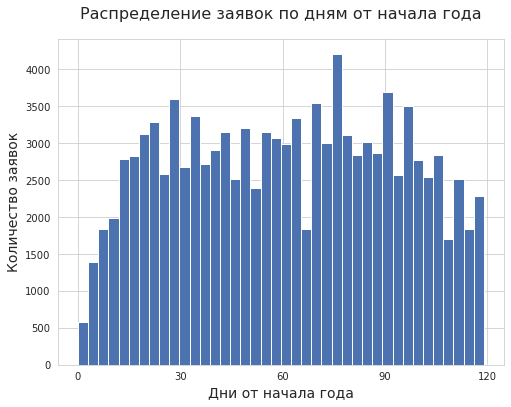

In [19]:
plt.rcParams["figure.figsize"] = [8, 6]
df['date_timedelta'].hist(bins=40)
plt.xlabel('Дни от начала года',
          fontsize=14)
plt.ylabel('Количество заявок',
          fontsize=14)
plt.xticks(np.linspace(0, 120, 5))
plt.title('Распределение заявок по дням от начала года',
          fontsize=16, pad = 20)

Визуализируем распределения параметров, чтобы понять, имеют ли дефолтные кредиты отличающееся распределение.

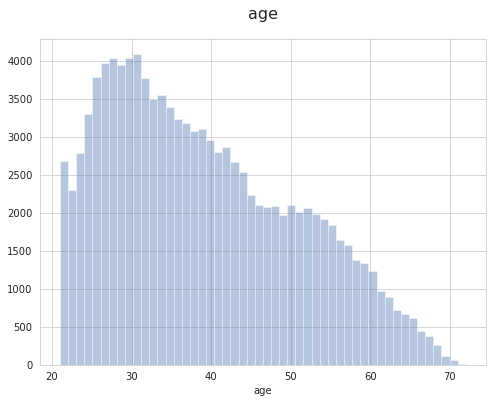

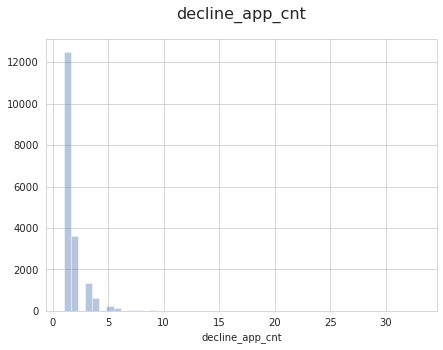

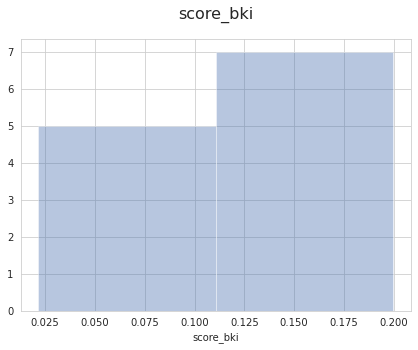

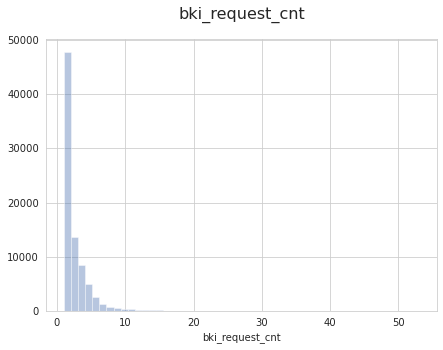

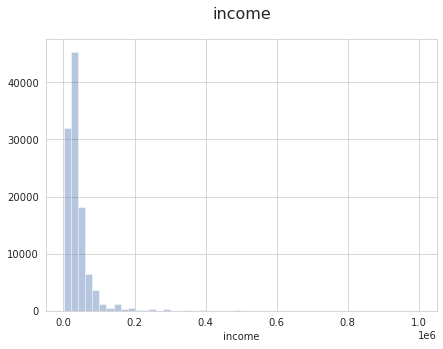

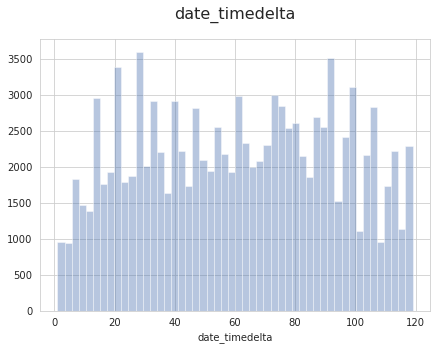

In [20]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i, fontsize=16, pad=20)
    plt.rcParams['figure.figsize'] = (7, 5)
    plt.show()

Используем логарифмирование для всех числовых признаков, кроме «score_bki», у которого нормальное распределение.

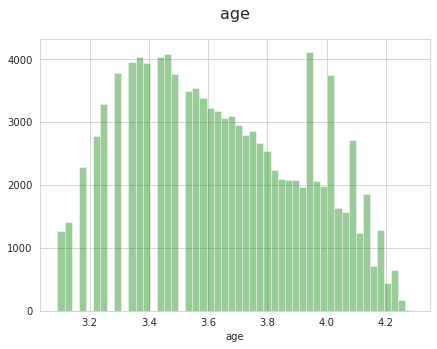

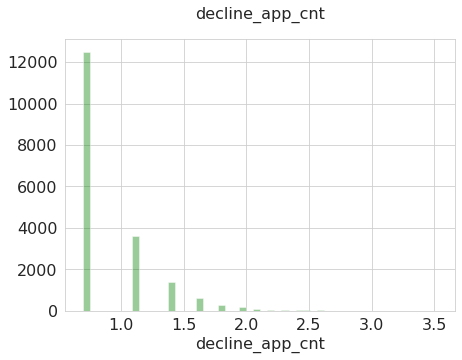

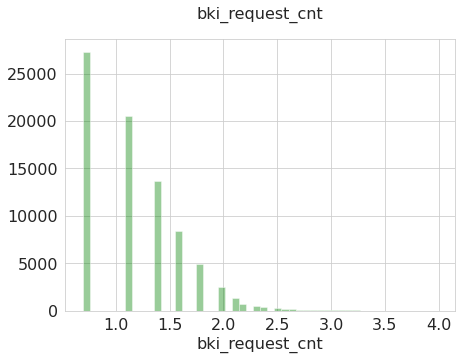

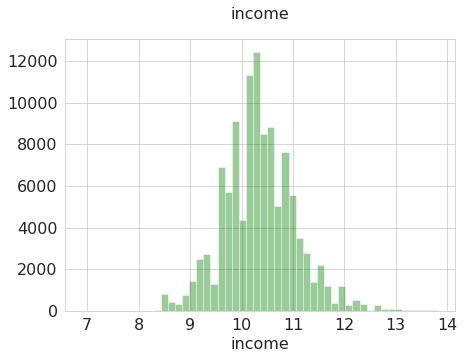

In [21]:
log_num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in log_num_cols:
    df[i] = np.log(df[i] + 1) # к логарифму добавляем 1 для того,
                              # чтобы обойти случай, когда df[i] = 0,
                              # потому как натуральный логарифм 0 - минус бесконечность
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(),
                 kde=False,
                 rug=False,
                 color='g')
    plt.title(i, fontsize=16, pad=20)
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['figure.figsize'] = (7, 5)
    plt.show()

Значительный результат только для признака «income». Это не очень хорошо, потому что для однофакторного дисперсионный анализ (ANOVA) и t-тестов жедательно, чтобы распределение было нормальным.

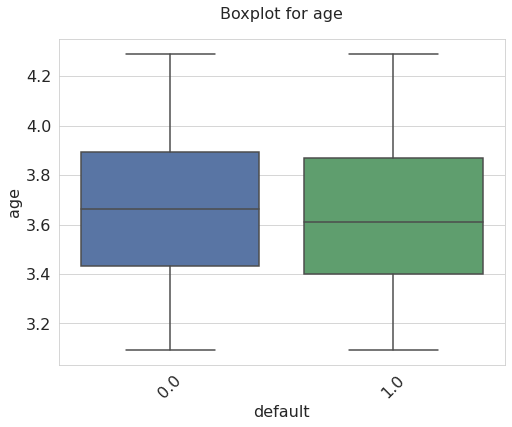

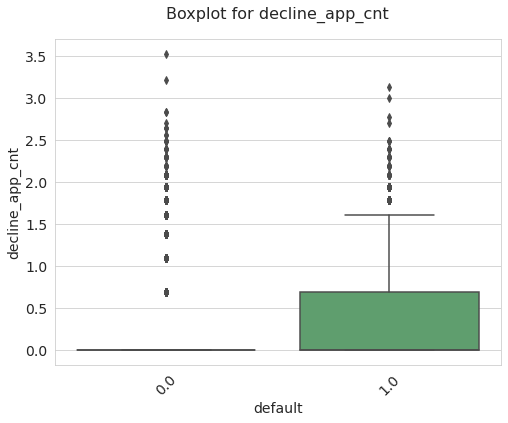

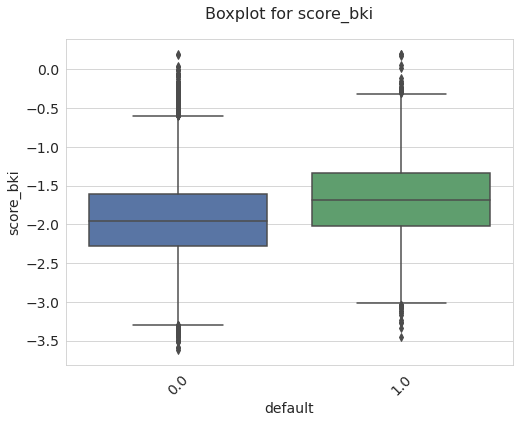

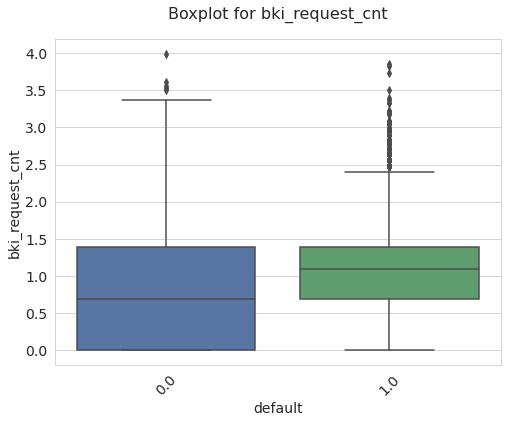

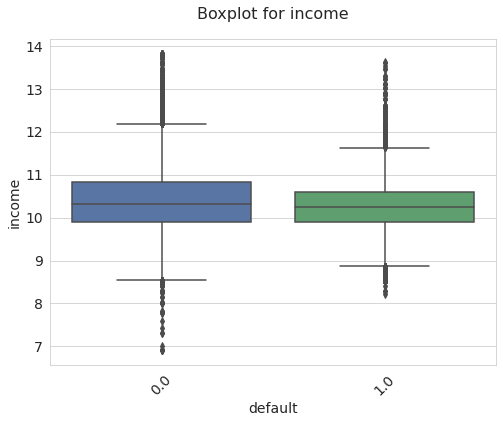

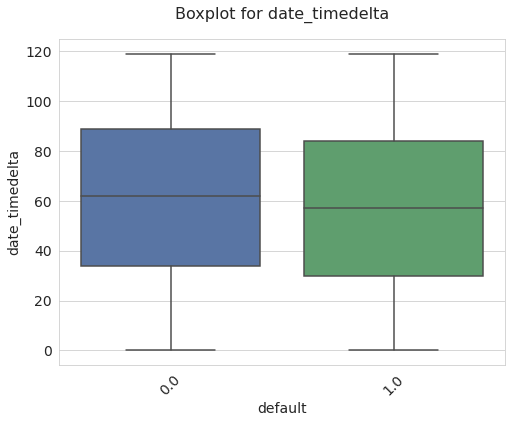

In [22]:
# Посмотрим на выбросы
for i in num_cols:
    get_boxplot(i)

На графике для «decline_app_cnt» видно, что есть выбросы.

Метод межквартильного расстояния выделяет как выбросы - все значения, находящиеся за пределами коробки. Посмотрим, сколько выбросов он найдет.

In [23]:
# Посмотрим на процентное количество выбросов для количественных признаков
for i in num_cols:
    out = outliers_detection(df[i])
    print('Для «{0}»: {1}%'. format(i, round((len(out)/len(df))*100, 2)))

Для «age»: 0.0%
Для «decline_app_cnt»: 16.96%
Для «score_bki»: 0.47%
Для «bki_request_cnt»: 0.01%
Для «income»: 2.37%
Для «date_timedelta»: 0.0%


In [24]:
drop_outliers(df, df['score_bki'])

drop_outliers(df, df['bki_request_cnt'])

drop_outliers(df, df['income'])

## Оценка корреляций

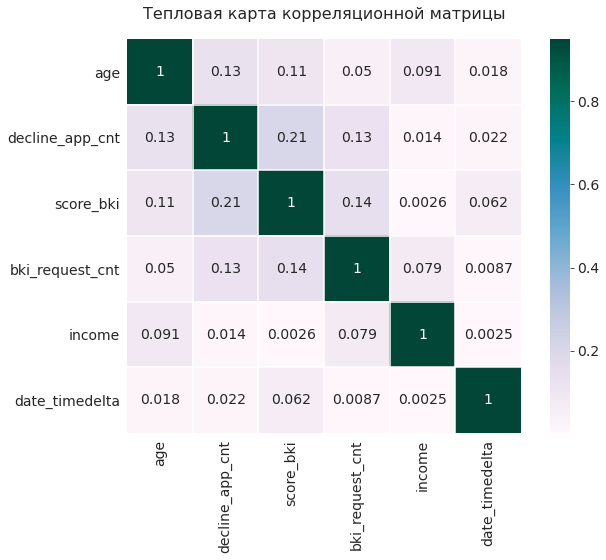

In [25]:
# Посмотрим на корреляционную матрицу
corrmat = df[num_cols].corr().abs()

f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corrmat, vmax=.95, annot=True, cmap='PuBuGn', square=True)
#cmap= 'twilight_shifted'
sources = corrmat.columns.get_level_values(0)
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        ax.axhline(len(sources) - i, c="w")
        ax.axvline(i, c="w")
ax.set_title('Тепловая карта корреляционной матрицы', fontsize=16, pad=20)
f.tight_layout()

## Значимость непрерывных переменных


Найдем влияющие на дефолт факторы по feature_importances

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

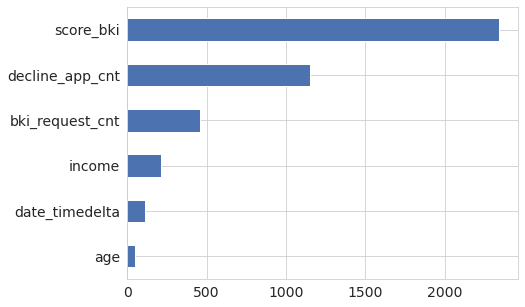

In [26]:
# оценка значимости числовых переменных

# указываем индекс [0], чтобы выводились значения
imp_num = pd.Series(f_classif(df[df.Train == 1][num_cols],
                              df[df.Train == 1]['default'])[0],
                    index=num_cols)
# сортировка по убыванию
imp_num.sort_values(inplace=True)
# barh - для переворачивания гистограммы
imp_num.plot(kind='barh')

Исходя из значений f-статистики для числовых признаков можно сделать вывод, что score_bki, decline_app_cnt и bki_request_cnt являются достаточно важными признаками, а income и age такими не являются. Будем помнить об этом и возможно избавимся от этих 2х признаков в дальнейшем.

Выделим значимые категориальные признаки для модели.

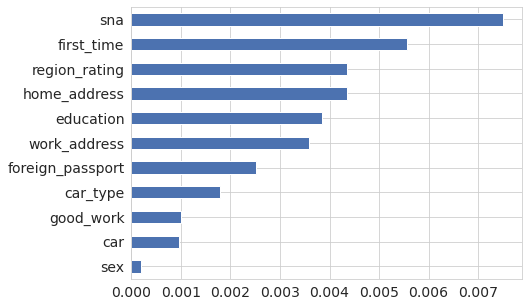

In [27]:
imp_cat = pd.Series(mutual_info_classif(df[df.Train == 1][bin_cols +
                                                              cat_cols],
                                        df[df.Train == 1]['default'],
                                        discrete_features=True),
                    index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самые значимые признаки: «sna», «first_time», «region_rating».  
Наименее значимые признаки: «sex», «car», «good_work».

## Data preprocessing

In [28]:
# Стандартизируем количественные признаки
ss = StandardScaler()
df[num_cols] = pd.DataFrame(ss.fit_transform(df[num_cols]),
                            columns=df[num_cols].columns)

In [29]:
# Data processing and model training.
data_temp = df.drop(['Train', 'client_id', 'app_date', 'default'], axis=1)
data_education_nan = data_temp[data_temp['education_nan'] == 1]
data_no_nan = data_temp[data_temp['education_nan'] == 0]
y = data_no_nan['education'].values
X = data_no_nan.drop(['education'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=random_seed)
model = RandomForestRegressor(n_estimators=100,
                              verbose=1,
                              n_jobs=-1,
                              random_state=random_seed)
model.fit(X_train, y_train)
y_pred = np.round(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [30]:
predict = np.round(
    model.predict(data_education_nan.drop(['education'], axis=1)))

index_education_nan = df[df['education_nan'] == 1].index
df.loc[index_education_nan, 'education'] = predict

df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)
df.sample(3)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,education_nan,date_timedelta,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
31177,105626,2014-04-24,0,-0.449689,0,0,-0.418815,0,-0.822372,0.770563,-0.786080,0,0.0,1,0,1.622043,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
78741,45781,2014-02-22,1,-1.258393,0,0,1.499512,0,0.229427,1.386150,0.168439,0,NaN,0,0,-0.279695,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
25092,67400,2014-03-16,0,1.600854,0,0,-0.418815,0,-0.286058,2.161699,-0.498037,0,0.0,1,0,0.406178,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0


## Model

*Логистическая регрессия — метод построения линейного классификатора, позволяющий оценивать апостериорные вероятности принадлежности объектов классам (в данном случае - дефолт/не дефолт).*

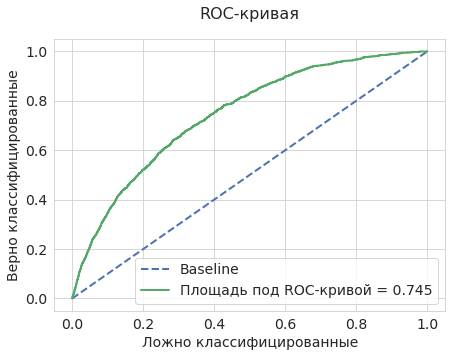

In [31]:
data_train = df.query('Train == 1').drop(
    ['Train', 'client_id', 'app_date'], axis=1)
data_test = df.query('Train == 0').drop(
    ['Train', 'client_id', 'app_date'], axis=1)


X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_seed)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)


probs = model.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--', linewidth=2)
plt.plot(fpr, tpr, label='Площадь под ROC-кривой = %0.3f' %
         roc_auc, linewidth=2)
plt.title('ROC-кривая', fontsize=16, pad=20)
plt.ylabel('Верно классифицированные')
plt.xlabel('Ложно классифицированные')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (10, 8)
plt.show()

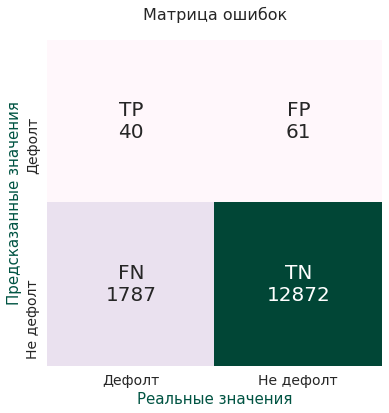

In [32]:
plt.rcParams['figure.figsize'] = (6, 6)
confusion_matrix_plot(y_test, y_pred)

In [33]:
# Checking the metrics.
all_metrics(y_test, y_pred, y_pred_prob)

accuracy     0.874797
precision    0.396040
recall       0.021894
F1           0.041494
ROC_AUC      0.744606
dtype: float64

## Regularization

In [34]:
C = np.logspace(0, 4, 10)
max_iter = 1000
epsilon_stop = 1e-3

hyperparameters = [
    {
        'penalty': ['l1'],
        'C': C,
        'solver': ['liblinear', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [max_iter],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['l2'],
        'C': C,
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [max_iter],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['none'],
        'C': C,
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [max_iter],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['elasticnet'],
        'C': C,
        'solver': ['saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [max_iter],
        'tol': [epsilon_stop]
    },
]

Создаем сетку поиска с использованием 5-кратной перекрестной проверки.

*GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров.*

In [35]:
'''
gridsearch = GridSearchCV(model,
                          hyperparameters,
                          scoring='f1',
                          n_jobs=-1,
                          cv=5)
gridsearch.fit(X_train, y_train)
new_model = gridsearch.best_estimator_
'''

"\ngridsearch = GridSearchCV(model,\n                          hyperparameters,\n                          scoring='f1',\n                          n_jobs=-1,\n                          cv=5)\ngridsearch.fit(X_train, y_train)\nnew_model = gridsearch.best_estimator_\n"

In [36]:
'''
# Смотрим на параметры
best_parameters = new_model.get_params()
print(f'Лучшие значения параметров:')
for name in best_parameters.keys():
    print(f'  {name} = {best_parameters[name]},')
'''

"\n# Смотрим на параметры\nbest_parameters = new_model.get_params()\nprint(f'Лучшие значения параметров:')\nfor name in best_parameters.keys():\n    print(f'  {name} = {best_parameters[name]},')\n"

Обучим модель, используя оптимальные гиперпараметры.

In [37]:
data_train = df.query('Train == 1').drop(
    ['Train', 'client_id', 'app_date'], axis=1)
data_test = df.query('Train == 0').drop(
    ['Train', 'client_id', 'app_date'], axis=1)

X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_seed)

In [38]:
# Оптимальные параметры
model = LogisticRegression(random_state=random_seed, 
                             C=46.416, 
                             class_weight='balanced', 
                             dual=False, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             l1_ratio=None,
                             multi_class='auto', 
                             n_jobs=None, 
                             penalty='l2', 
                             solver='sag',
                             verbose=0, 
                             warm_start=False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [39]:
# Посмотрим на метрики
all_metrics(y_test, y_pred, y_pred_prob)

accuracy     0.671206
precision    0.226599
recall       0.686371
F1           0.340715
ROC_AUC      0.744121
dtype: float64

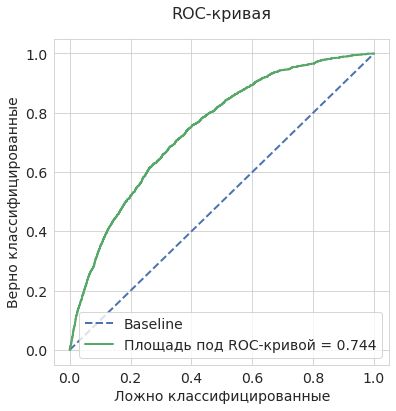

In [40]:
# Построим на ROC-кривую
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--', linewidth=2)
plt.plot(fpr, tpr, label='Площадь под ROC-кривой = %0.3f' %
         roc_auc, linewidth=2)
plt.title('ROC-кривая', fontsize=16, pad=20)
plt.ylabel('Верно классифицированные')
plt.xlabel('Ложно классифицированные')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

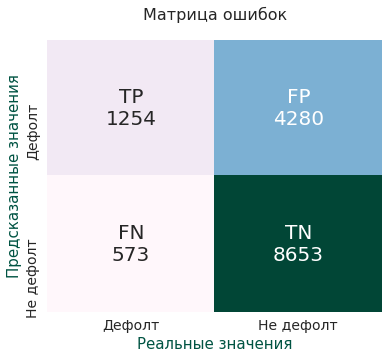

In [41]:
# Посмотрим на матрицу ошибок
plt.rcParams['figure.figsize'] = (6, 5)
confusion_matrix_plot(y_test, y_pred)

## Cross-validation

In [42]:
# Разделим данные на тренировочную и тестовую части
data_train = df.query('Train == 1').drop(
    ['Train', 'client_id', 'app_date'], axis=1)
data_test = df.query('Train == 0').drop(
    ['Train', 'client_id', 'app_date'], axis=1)

X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=random_seed)

In [43]:
# Обучим модель 4 раза с разными подобранными параметрами

model_1 = LogisticRegression(C=1,
                             class_weight='balanced',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=50,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l2',
                             random_state=42,
                             solver='liblinear',
                             tol=0.001,
                             verbose=0,
                             warm_start=False)

In [44]:
model_2 = LogisticRegression(random_state=random_seed, 
                             C=46.416, 
                             class_weight='balanced', 
                             dual=False, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             l1_ratio=None,
                             max_iter = 1000,
                             multi_class='auto', 
                             n_jobs=None, 
                             penalty='l2', 
                             solver='sag',
                             tol = 0.001,
                             verbose=0, 
                             warm_start=False)

In [45]:
model_3 = LogisticRegression(C=0.023,
                             class_weight='balanced',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=50,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l2',
                             random_state=42,
                             solver='liblinear',
                             tol=0.001,
                             verbose=0,
                             warm_start=False)

In [46]:
model_4 = LogisticRegression(random_state=random_seed, 
                             C=2.8, 
                             class_weight='balanced', 
                             dual=False, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             l1_ratio=None,
                             max_iter = 1000,
                             multi_class='auto', 
                             n_jobs=None, 
                             penalty='l1', 
                             solver='saga',
                             tol = 0.001,
                             verbose=0, 
                             warm_start=False)

In [47]:
model_5 = LogisticRegression(random_state=random_seed, 
                             C=100, 
                             class_weight='balanced', 
                             dual=False, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             l1_ratio=None,
                             max_iter = 1000,
                             multi_class='auto', 
                             n_jobs=None, 
                             penalty='l1', 
                             solver='liblinear',
                             tol = 0.001,
                             verbose=0, 
                             warm_start=False)

In [48]:
model_6 = LogisticRegression(random_state=random_seed, 
                             C=0.28, 
                             class_weight='balanced', 
                             dual=False, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             l1_ratio=None,
                             max_iter = 1000,
                             multi_class='auto', 
                             n_jobs=None, 
                             penalty='l2', 
                             solver='liblinear',
                             tol = 0.001,
                             verbose=0, 
                             warm_start=False)

Используем «cross_val_score» для k-fold кросс-валидации 

In [49]:
# Посчитаем метрику F1 для 10 фолдов
scores_1 = cross_val_score(model_1, X, y, cv=10, scoring='f1')
scores_2 = cross_val_score(model_2, X, y, cv=10, scoring='f1')
scores_3 = cross_val_score(model_3, X, y, cv=10, scoring='f1')
scores_4 = cross_val_score(model_4, X, y, cv=10, scoring='f1')
scores_5 = cross_val_score(model_5, X, y, cv=10, scoring='f1')
scores_6 = cross_val_score(model_6, X, y, cv=10, scoring='f1')

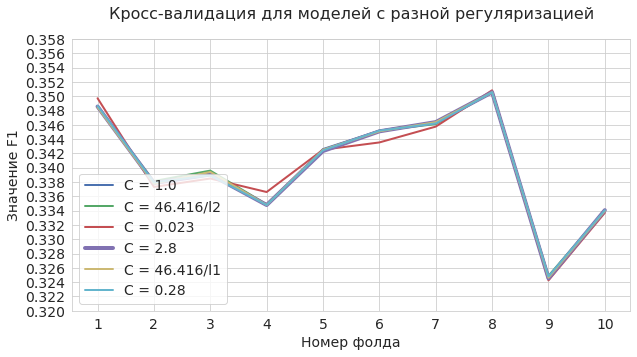

In [50]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores_1, label = 'C = 1.0', linewidth=2)
plt.plot(x, scores_2, label = 'C = 46.416/l2', linewidth=2)
plt.plot(x, scores_3, label = 'C = 0.023', linewidth=2)
plt.plot(x, scores_4, label = 'C = 2.8', linewidth=4)
plt.plot(x, scores_5, label = 'C = 46.416/l1', linewidth=2)
plt.plot(x, scores_6, label = 'C = 0.28', linewidth=2)

plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией',
          fontsize=16, pad=20)
plt.ylabel('Значение F1', fontsize=14)
plt.xlabel('Номер фолда', fontsize=14)
ax.set_xticks(x)
yticks = np.arange(0.32, 0.36, 0.002)
ax.set_yticks(yticks)
ax.grid(True)

## Submission

In [51]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

model = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l1', 
                           solver='liblinear', 
                           verbose=0, 
                           warm_start=False,
                           max_iter=1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]

In [52]:
X_test = data_test.drop(['default'], axis=1)
y_pred_prob = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test['client_id'])
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)